<a href="https://colab.research.google.com/github/Josh1313/PRUEBA_VISUALCODE/blob/master/2nd_STEP_Monday_DPL_of_transf_learning_catsanddogs_basic_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connectar a Drive

# En este notebook haremos unos ajustes al notebook que lo entrenamos con perros y gatos borraremos el preprocesamiento y nos quedaremos con el modelo y congelaremos el proceso y cargaremos nuevos datos para que predica mejor,FINE TUNNING

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Librerias

In [3]:
from tensorflow import keras as ks
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model

# Variables de entorno

<font color="#FF0000">Aquí definireis vuestra ruta del proyecto de perros y Gatos</font>

In [4]:
ANCHO_IMAGEN = 150
ALTURA_IMAGEN=150
IMAGE_SIZE = (ANCHO_IMAGEN, ALTURA_IMAGEN)
CANALES_IMAGENES = 3

ruta_archivos = '/content/drive/MyDrive/DPL456/'

# Cargaremos datos en NPZ


In [5]:
dict_npz = np.load(ruta_archivos+'xy_train_img.npz')
x_train_img = dict_npz['x']
y_train_img = dict_npz['y']

dict_npz = np.load(ruta_archivos+'xy_test_img.npz')
x_test_img = dict_npz['x']
y_test_img = dict_npz['y']

dict_npz = np.load(ruta_archivos+'xy_val_img.npz')
x_val_img = dict_npz['x']
y_val_img = dict_npz['y']

In [6]:
x_train_scaled = x_train_img / 255.
x_test_scaled = x_test_img / 255.
x_val_scaled = x_val_img / 255.

In [7]:
y_train_img

array(['cat', 'cat', 'cat', ..., 'dog', 'dog', 'dog'], dtype='<U3')

# Montamos la Red Neuronal

## Cargar la parte de extraccion de features de VGG16

In [8]:
# Creemos una red que será extracción de features basada en VGG16 entrenada con ImageNet

In [9]:
model_vgg16 = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(150,150,3))# Son los pixeles de las imagenes (features)
# include_top=false, es para agarrar la parte que necesitamos solo el preprocesamiento
model_vgg16.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

Desde aca le extraemos la ultima capa del modelo y se la asiganmos a una variable despues a esa variable le asignamos la funcion flatten para que aplane la salida que es el output del modelo

In [10]:
output = model_vgg16.layers[-1].output  # en este paso  nos quedamos  y lo juntamos
output

<KerasTensor: shape=(None, 4, 4, 512) dtype=float32 (created by layer 'block5_pool')>

In [11]:
output_layer = ks.layers.Flatten()(output)
output_layer

<KerasTensor: shape=(None, 8192) dtype=float32 (created by layer 'flatten')>

In [12]:
model_prevgg16 = Model(model_vgg16.input, output_layer)
model_prevgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [13]:
# Veamos como va lo de "congelar" capas de entrenamiento

In [14]:
pd.set_option("display.max_colwidth", True)
layers = [(layer, layer.name, layer.trainable) for layer in model_prevgg16.layers]
pd.DataFrame(layers, columns=("Layer","Name","Is Trainable?"))

,Layer,Name,Is Trainable?
0,<keras.engine.input_layer.InputLayer object at 0x7f9bfb605480>,input_1,True
1,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f9bfb604dc0>,block1_conv1,True
2,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f9bfb6045b0>,block1_conv2,True
3,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f9bfb6067d0>,block1_pool,True
4,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f9bfb607100>,block2_conv1,True
5,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f9bfb607f40>,block2_conv2,True
6,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f9bfb606980>,block2_pool,True
7,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f9bfb607640>,block3_conv1,True
8,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f9baacd5870>,block3_conv2,True
9,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f9bfb606920>,block3_conv3,True


In [15]:
model_prevgg16.trainable

True

In [16]:
# Despues del bloque 4 de convulciones lo haremos true lo demas lo congelaremos y los pondremos false no harana nada

In [17]:
trainable = False
for layer in model_prevgg16.layers:
  if layer.name == "block4_conv1":
    trainable = True

  layer.trainable = trainable


In [18]:
#layers = [(layer, layer.name, layer.trainable) for layer in model_prevgg16.layers]
#pd.DataFrame(layers, columns=("Layer","Name","Is Trainable?"))

In [19]:
model_prevgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [35]:
# como pueden ver arriba aca se se puede ver el resultado del congelamiento de las capas

# Montemos la red de clasificación

In [36]:
# aca hicimos una modificacion del primer notebook pusimos el modelo de una vez

In [20]:
model_post_vgg = ks.Sequential()

model_post_vgg.add(model_prevgg16)
model_post_vgg.add(ks.layers.Dense(512, activation='relu'))
model_post_vgg.add(ks.layers.Dropout(0.3))
model_post_vgg.add(ks.layers.Dense(512, activation='relu'))
model_post_vgg.add(ks.layers.Dropout(0.3))
model_post_vgg.add(ks.layers.Dense(1, activation='sigmoid'))

model_post_vgg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 8192)              14714688  
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 19,172,673
Trainable params: 17,437,185
No

In [21]:
# se pueden fijar en el resultado arriba la cantidades entrenable y las que no osea las congeladas

# Creamos un optimizador

In [22]:
from tensorflow.keras.optimizers import Adam

In [23]:
# Aca le modificamosun cero mas ya que no entrenaba nada!

In [24]:
new_adam = Adam(learning_rate=0.00005)


In [25]:
# a continuacion modificamos la parte de optimizer adan = new_adam

In [26]:
model_post_vgg.compile(loss='binary_crossentropy', optimizer=new_adam, metrics=['accuracy'])

# Early stopping!!

In [27]:
callback = EarlyStopping(monitor='val_loss', patience=5)

# Encoding de etiquetas

In [28]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train_img)
y_train_encoded = le.transform(y_train_img)
y_val_encoded = le.transform(y_val_img)
y_test_encoded = le.transform(y_test_img)

In [29]:
print(np.array(y_train_img))
print(np.array(y_train_encoded))

y_train_encoded

['cat' 'cat' 'cat' ... 'dog' 'dog' 'dog']
[0 0 0 ... 1 1 1]


array([0, 0, 0, ..., 1, 1, 1])

# Entrenar se modifica las variable a x_train_scaled, batch size, x_val_scaled

In [30]:
history = model_post_vgg.fit(x=x_train_scaled, y=y_train_encoded, batch_size=32,
                             epochs=100, callbacks=[callback],
                             validation_data=(x_val_scaled, y_val_encoded))

Epoch 1/100
157/157 [==============================] - 39s 136ms/step - loss: 0.2849 - accuracy: 0.8686 - val_loss: 0.1428 - val_accuracy: 0.9440
Epoch 2/100
157/157 [==============================] - 20s 131ms/step - loss: 0.1167 - accuracy: 0.9528 - val_loss: 0.1459 - val_accuracy: 0.9420
Epoch 3/100
157/157 [==============================] - 21s 132ms/step - loss: 0.0602 - accuracy: 0.9770 - val_loss: 0.1519 - val_accuracy: 0.9530
Epoch 4/100
157/157 [==============================] - 21s 131ms/step - loss: 0.0299 - accuracy: 0.9892 - val_loss: 0.1730 - val_accuracy: 0.9520
Epoch 5/100
157/157 [==============================] - 20s 129ms/step - loss: 0.0349 - accuracy: 0.9874 - val_loss: 0.1786 - val_accuracy: 0.9360
Epoch 6/100
157/157 [==============================] - 20s 129ms/step - loss: 0.0184 - accuracy: 0.9930 - val_loss: 0.1756 - val_accuracy: 0.9440


# Guardamos el modelo

Aquí tenemos que guardar el modelo simple, pero tambien hemos de guardar, o bien el modelo de preproceso o bien los datos de test procesados en NPZ...

In [31]:
 #Modelo post VGG16
model_post_vgg.save(ruta_archivos+'model_with_basic_transfer_learning_post_vgg16.h5')



# Miremos que tal rinde el modelo en errores y accuracy

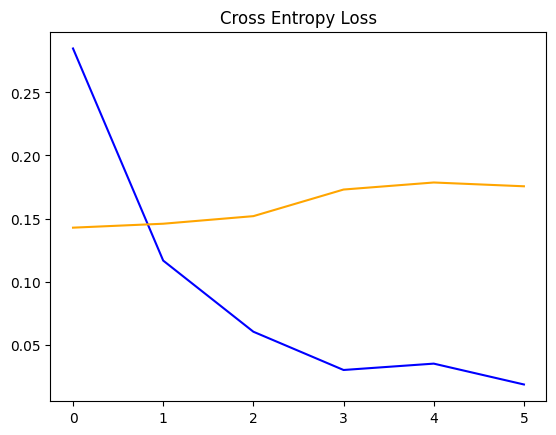

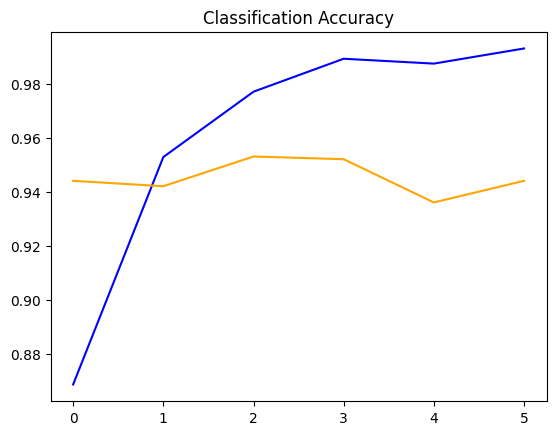

In [32]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.show()

In [33]:
# acontinuacion se le hizo la actualizacion de variables

In [34]:
_, acc = model_post_vgg.evaluate(x_test_scaled, y_test_encoded, verbose=0)
print('Modelo con Basic Transfer Learning > %.3f' % (acc * 100.0))


Modelo con Basic Transfer Learning > 96.300
